<h5> Autheurs:</h5> 
    Han Teunissen <br>
    Steffen de Jong <br>
    Christaan Posthuma <br>
    Harm Laurense 

# Introductie

Image analysis is een fundamentele tool voor het herkennen, onderscheiden en kwantificeren van diverse soorten afbeeldingen.<br> 
De enorme groei van hardware platformen en software frameworks heeft tot significante verbeteringen geleid in de analyse van afbeeldingen. <br>
Om ervaring in dit gebied op te doen hebben wij gekozen om een classifier te maken die honden en katten kan classificeren uit afbeeldingen.<br>
De classifier is gemaakt m.b.v . een python script (python 3.8), waarin gebruik gemaakt is van Keras (versie 2.3) en Tensorflow (versie 2.0).<br>
Het model is gedraaid op zowel de CPU als de GPU (CUDA CDNN 11.2) om de mogelijke tijdswinst te bepalen.<br>
<br>
De afbgeeldingen die gebruikt is is verkregen vanvan de kaggle competitie Dogs vs. Cats. <br>
Vanwege de hoeveelheid afbeeldingen is alleen de trainset gebruikt. https://www.kaggle.com/c/dogs-vs-cats/data.

In [1]:
from os import listdir, makedirs
import pandas as pd
from shutil import copyfile
import h5py
from numpy import asarray
import itertools
from numpy import save
import numpy
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from random import seed, random
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Methode

Hieronder worden directories gemaakt voor de te gebruiken afbeeldingen.<br>
Deze worden vervolgens ingedeeld in een directory voor de trainset en een voor de testset.<br> Daarnaast wordt binnen deze folders aparte directories gemaakt voor honden afbeeldingen en katten afbeeldingen.<br>
In het geval dat deze directories al bestaan worden deze zo behouden.<br>

In [ ]:
# create directories

dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

Hieronder worden twee subsets gemaakt van de totale dataset, namelijk één voor de trainset en één voor de testset (holdout methode).<br>
Er is gekozen om 25% van de data apart te houden voor de testset en de overige 75% te gebruiken voor de trainset. <br>

In [ ]:
# !!! skip this cell when working in docker enverioment!!!


# make subsets
dataset_home = 'dataset_dogs_vs_cats/'
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + file
        copyfile(src, dst)

# Het model aanmaken
Voordat de trainset wordt betrokken in het maken van het model wordt er eerst een basis van het model gemaakt.<br> 
Voor het uiteindelijke model hebben we het VGG16 model gebruikt. Dit model bestaat uit 2 delen, namelijk: De feature extraction en een 16-laags classifier.<br>
Omdat we voor onze doeleinden alleen de extraction nodig hebben, is voor de include_top variabele een ‘false’ meegegeven.<br>
De input_shape is op 224x224 gezet, omdat het VGG16 model hierop is getraind.<br>
Dit is een belangrijke stap die later ook wordt uitgevoerd tijdens de pre-processing (resizing). Het is nodig dit toe te passen op afbeeldingen die worden gebruikt voor zowel het trainen als het testen. <br>

Vervolgens wordt de keras.Flatten functie gebruikt om layers aan het VGG16 model toe te voegen.<br> 
Verder wordt er nog een optimalisatie stap genomen met de keras.SGD functie. <br>
Hier is de learning rate op 0.001 gezet in plaats van de default waarde van 0.01.<br> 
Deze stap is gedaan om de accuracy te verhogen.<br> 
Als laatste wordt het model nog gecompiled en daarbij wordt de optimizer de loss en de metrics gedefinieerd.<br>


In [2]:
def define_model_VGG16():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Trainset en testset maken

In de variabele datagen vindt een deel van het preprocessen plaats, waarin het model ervanuit gaat dat alle afbeeldingen gecentered zijn.<br>
De afbeeldingen worden uit de directories gelezen, en een binaire classificatie wordt toegepast (cat=0 / dog =1).



In [3]:
datagen = ImageDataGenerator(featurewise_center=True)

train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                       class_mode='binary', batch_size=64, target_size=(224, 224), shuffle=False)
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                      class_mode='binary', batch_size=64, target_size=(224, 224), shuffle=False)

Found 18700 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


# De data fitten

Hieronder wordt het model getraind met 3 en 10 epochs.<br>
De variabele history bevat informatie in een dictionairy die later voor het plotten van de grafieken wordt gebruikt.<br>



In [4]:
model3 = define_model_VGG16()
history3 = model3.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=3, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
293/293 [==============================] - 118s 403ms/step - loss: 0.5117 - accuracy: 0.9472 - val_loss: 0.0827 - val_accuracy: 0.9686
Epoch 2/3
293/293 [==============================] - 120s 410ms/step - loss: 0.0538 - accuracy: 0.9778 - val_loss: 0.0825 - val_accuracy: 0.9711
Epoch 3/3
293/293 [==============================] - 120s 411ms/step - loss: 0.0262 - accuracy: 0.9891 - val_loss: 0.0963 - val_accuracy: 0.9692


In [6]:
model10 = define_model_VGG16()
history10 = model10.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)

Epoch 1/10
293/293 [==============================] - 119s 406ms/step - loss: 0.5312 - accuracy: 0.9432 - val_loss: 0.0840 - val_accuracy: 0.9662
Epoch 2/10
293/293 [==============================] - 119s 406ms/step - loss: 0.0582 - accuracy: 0.9783 - val_loss: 0.0843 - val_accuracy: 0.9670
Epoch 3/10
293/293 [==============================] - 120s 411ms/step - loss: 0.0258 - accuracy: 0.9897 - val_loss: 0.0946 - val_accuracy: 0.9680
Epoch 4/10
293/293 [==============================] - 119s 406ms/step - loss: 0.0100 - accuracy: 0.9960 - val_loss: 0.1109 - val_accuracy: 0.9691
Epoch 5/10
293/293 [==============================] - 119s 408ms/step - loss: 0.0038 - accuracy: 0.9983 - val_loss: 0.1299 - val_accuracy: 0.9702
Epoch 6/10
293/293 [==============================] - 119s 407ms/step - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.1433 - val_accuracy: 0.9708
Epoch 7/10
293/293 [==============================] - 119s 407ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 0.1527 -

# Accuracy berekenen
In de model.evaluate_generator wordt de accuracy bepaald door gebruik te maken van de testset. <br>
De verbetering in accuracy is te verwaarlozen na 3 epochs, beiden hebben namelijk dezelfde accuracy.<br>
Dit is ook terug tezien in de Plots.

In [5]:
_, acc = model3.evaluate_generator(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

Instructions for updating:
Please use Model.evaluate, which supports generators.
99/99 [==============================] - 30s 301ms/step - loss: 0.0963 - accuracy: 0.9692
> 96.922


In [7]:
_, acc = model10.evaluate_generator(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

99/99 [==============================] - 26s 268ms/step - loss: 0.1683 - accuracy: 0.9702
> 97.017


# Plots maken


In [ ]:
def make_plot(hist):
    fig, axs = plt.subplots(2, figsize=[10,10])

    axs[0].set_title('Cross Entropy Loss')
    axs[0].plot(hist.history['loss'], color='blue', label='train')
    axs[0].plot(hist.history['val_loss'], color='orange', label='test')
    axs[0].set_ylabel("entropy loss")
    axs[0].set_xlabel("epochs")
    axs[0].legend()

    axs[1].set_title('Classification Accuracy')
    axs[1].plot(hist.history['accuracy'], color='blue', label='train')
    axs[1].plot(hist.history['val_accuracy'], color='orange', label='test')
    axs[1].set_ylabel("accuracy")
    axs[1].set_xlabel("epochs")
    axs[1].legend()

    plt.tight_layout()

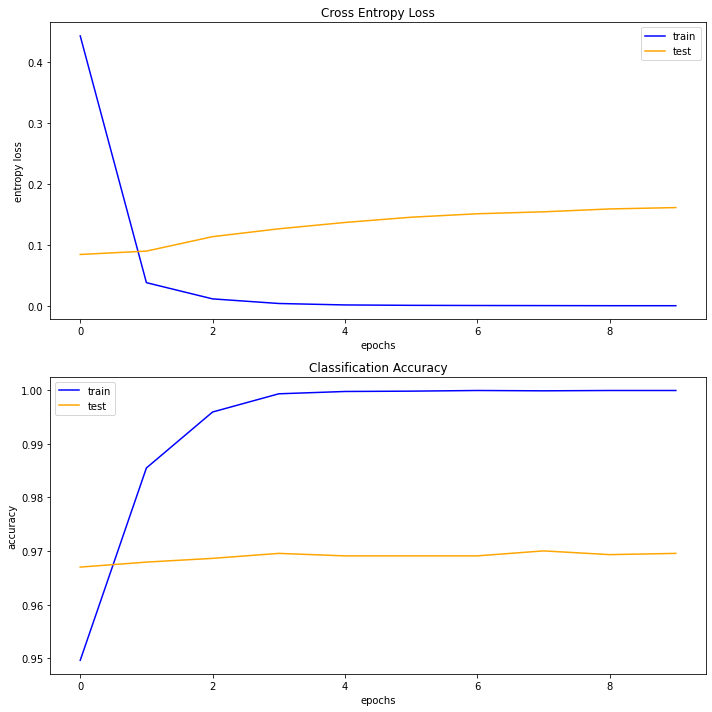

In [ ]:
make_plot(history10)

Zoals hierboven te zien is, begint de accuracy van de testset te stagneren na 1 epochs. Deze heeft dan ongeveer een accuracy van 97%.<br>
De accuracy van de train data stagneert ook ongeveer tussen 2-4 epoch en heeft dan een accuracy van 99%-100%.<br>
De entropy loss blijft bij de test tussen 0.08 en 0.18 zitten terwijl er tussen 1 en 2 epoch een grote daling maakt en vervolgens langzaam stagneert op ongeveer 0.0.<br>
Er is dus geen grote verbetering meer te zien na 3~4 epochs in de testset.

# Onze eigen afbeeldingen

We hebben er voor gekozen om ook onze eigen afbeeldingen te classificeren als extra controle. <br>
Onze eigen set bestaat uit 100 katten en honden afbeeldingen.

In [9]:
datagen = ImageDataGenerator(featurewise_center=True)
onze_fotos = datagen.flow_from_directory('onze_fotos/test1',
                                      class_mode='binary', batch_size=64, target_size=(224, 224), shuffle=False)

Found 200 images belonging to 2 classes.


Hieronder is te zien dat ons model ook onze nieuwe afbeeldingen goed kan classificeren.

In [10]:
prediction3 = model3.evaluate(onze_fotos, verbose=1)
prediction10 = model10.evaluate(onze_fotos, verbose=1)
print("3 epochs ",  prediction3[1])
print("10 epochs ",  prediction10[1])

4/4 [==============================] - 1s 148ms/step - loss: 0.7331 - accuracy: 0.8850
3 epochs  0.8450000286102295
10 epochs  0.8849999904632568


In [18]:
def make_roc(mod, data):
    predicted = mod.predict(data) 
    true_class = data.classes

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_class, predicted)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.figure(1)
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve onze data')
    plt.legend(loc='best')
    plt.show()

In [16]:
def make_confusion_matrix(mod, data):
    predicted = mod.predict(data) 
    true_class = data.classes
    res = []
    for i in predicted:
        if i >= 0.5:
            res.append(1)
        else :
            res.append(0)

    classes = ['cat','dog']

    cm = confusion_matrix(y_true=true_class, y_pred=res)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("confusion matrix onze data")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

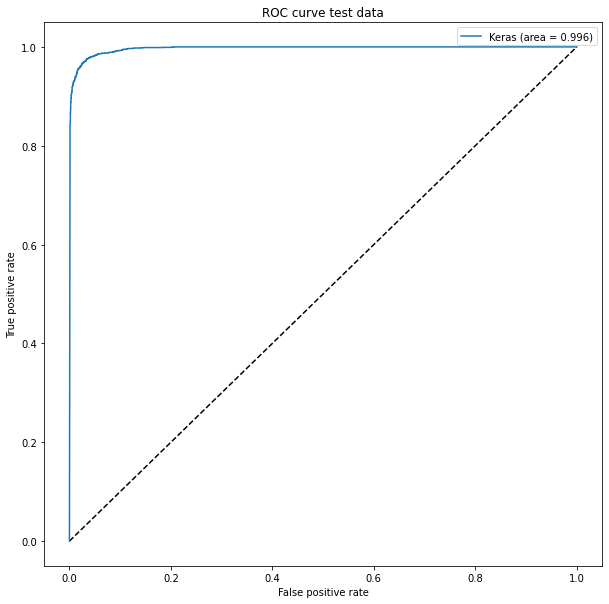

In [14]:
make_roc(model10, test_it)

Het programma heeft hoge verhouding van true positives, ten opzichte van de hoeveelheid false positives. <br>
De stippellijn houd een random classificatie in van de dataset, en het programma doet dat dus significant beter. <br>
De area houd in dat er een 98.1% kans is dat de positieve instance hoger wordt geclassificeerd als de negatieve instance.


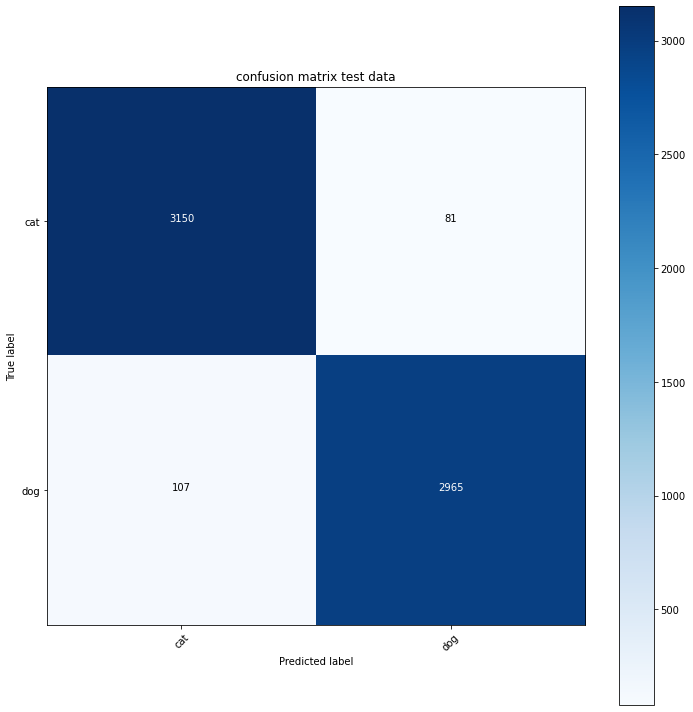

In [15]:
make_confusion_matrix(model10, test_it)

Bovenstaande confusion matrix is gemaakt met de testset.<br>
In deze confusion matrix kan er worden gezien dat de honden slechter zijn geclassificeerd dan katten. <br>
Dit verschil is wel verwaarloosbaar klein (16 op ongeveer 6000) vanwege de hoeveelheid afbeeldingen.

<Figure size 432x288 with 0 Axes>

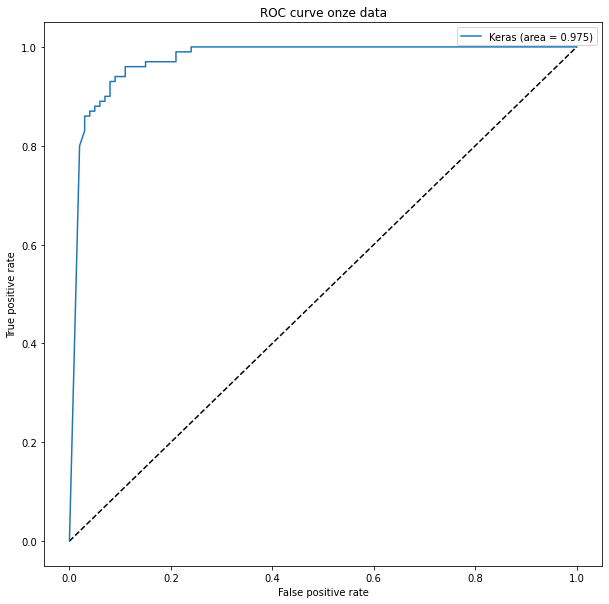

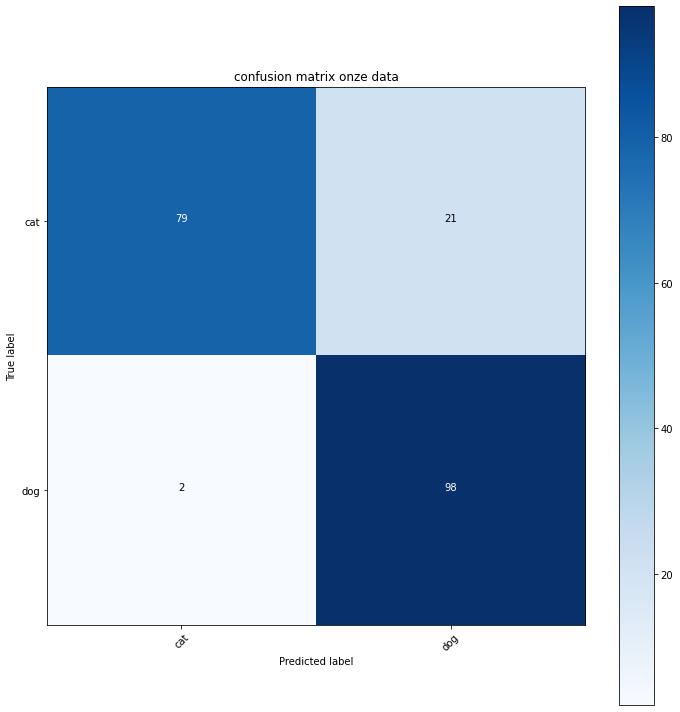

In [19]:
make_roc(model10, onze_fotos)
make_confusion_matrix(model10, onze_fotos)

Bovenstaande confusion matrix en roc curve is gemaakt met een afzonderlijk zelfgemaakte subset van honden en katten.<br>
Deze subset is dus niet onderdeel van de oorspronkelijke 25.000 afbeeldingen. <br>
In deze confusion matrix kan er worden gezien dat de katten slechter zijn geclassificeerd dan honden. <br>
Dit komt overeen met onze verwachtingen omdat de foto’s van de katten meer ‘occlusion’ bevatten dan de honden foto’s en de testset is vele malen kleiner.

# Discussie & Conclusie

Ons doel voor dit project was om honden en katten te classificeren uit afbeeldingen, met behulp van een eigen gemaakte classifier. <br>
Wij zijn geslaagd in het maken van een classifier die in staat is om deze classificatie uit te voeren met een accuracy van ongeveer 97%.<br>
\Hierbij is gebruik gemaakt van de holdout methode op een totale dataset van 25.000 afbeeldingen.<br>
De trainset bedraagt 75% (18.750 afbeeldingen) van de totale dataset, en de testset de overige 25% (6.250 afbeeldingen).<br>
Wij hebben ook een afzonderlijke testset gemaakt met zowel 100 katten afbeeldingen als 100 honden afbeeldingen. <br>
Hierbij ondervonden wij een accuracy van ongeveer 88%. <br>
Wat te verwachten is aangezien de katten afbeeldingen meer occlusion bevatten en de hoeveelheid afbeeldingen in verhouding lager is vergeleken met de oorspronkelijke set afbeeldingen.<br>


Wij hebben gezien dat het draaien van het model op de GPU (CUDA) een bijna 24-voudige snelheidswinst heeft op de CPU. <br>
Deze meting was uitgevoerd op NVIDIA GeForce GTX 1070 Intel(R)Core(TM)i7-8700 CPU @ 3.20GHZ.

We hebben vooronderzoek verricht naar verschillende modellen, waarin het VGG16 model en het VGG3 model het meest belovend waren.<br>
Het VGG16 model heeft bij onze dataset een hogere accuracy (97%) dan het VGG3 model (79%).<br>
Het VGG3 model heeft in tegenstelling tot het VGG16 model een hogere snelheid per epoch maar uit de optimalisatie bleek dat een verbetering in performance al stagneert na 3-4 epochs. <br>
Er zijn dus niet genoeg voordelen om het gebruik van VGG3 te prefereren over het VGG16 model.<br>
Voor het optimaliseren van het model, worden als eerst de afbeeldingen ingeladen en getransformeerd naar een grootte van 244x244 pixels. <br>
Dit wordt gedaan omdat het VGG16 model getraind is op dit formaat [bron]. <br>
Verder is er met de keras.SGD nog verder geoptimaliseerd door de learning rate aan te passen van 0.01 (default waarde) naar 0.001.<br>
Dit verhoogde de accuracy van 75% naar 97%. Daarnaast zijn er met de functie keras.ImageDataGenerator functie de images gecentered omdat het VGG16 model hier op getraind is.<br>
Verdere optimalisatie van dit model is mogelijk maar er zal met een performance van 97% niet veel winst meer gemaakt kunnen worden. 
